In [1]:
DEBUG = True

if DEBUG:
    import os
    import sys
    sys.path.append(os.path.abspath(os.getcwd()).replace('notebooks', ''))
else:
    !pip install --upgrade tspiral

In [2]:
import numpy as np
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV, train_test_split

from tspiral.forecasting import *
from tspiral.model_selection import TemporalSplit

In [3]:
# utility function to generate data

def gen_sinusoidal(timesteps, amp, freq, noise):
    X = np.arange(timesteps)
    e = np.random.normal(0,noise, (timesteps,))
    y = amp*np.sin(X*(2*np.pi/freq))+e
    return y

def gen_randomwalk(timesteps, noise):
    y = np.random.normal(0,noise, (timesteps,))
    return y.cumsum()

def gen_ts(timesteps, random_state=0):
    np.random.seed(random_state)
    seas1 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24, noise=4)
    seas2 = gen_sinusoidal(timesteps=timesteps, amp=10, freq=24*7, noise=4)
    rw = gen_randomwalk(timesteps=timesteps, noise=1)
    X = np.linspace(0,10, timesteps).reshape(-1,1)
    X = np.power(X, [1,2])
    trend = LinearRegression().fit(X, rw).predict(X)
    return seas1 + seas2 + trend

In [4]:
# generate data

n_series, timesteps = 5, 2_000

df = {}
for i in range(n_series):
    df[i] = gen_ts(timesteps, i)
df = pd.DataFrame(df)

exog = pd.DataFrame({
    'sin24': gen_sinusoidal(timesteps=timesteps, amp=1, freq=24, noise=0),
    'sin168': gen_sinusoidal(timesteps=timesteps, amp=1, freq=24*7, noise=0)
})


df.shape, exog.shape

((2000, 5), (2000, 2))

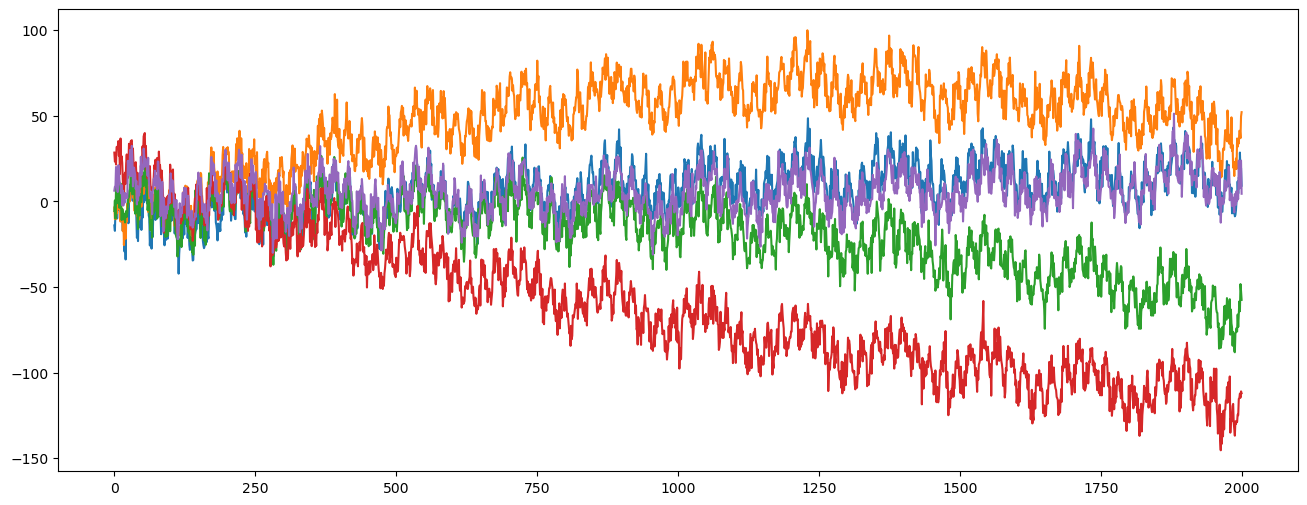

In [5]:
# plot timeseries

_ = df.plot(legend=False, figsize=(16,6))

In [6]:
# train test split

test_size = 300

df_train, df_test = train_test_split(df, test_size=test_size, shuffle=False)

df_train = pd.melt(df_train, value_vars=df.columns, ignore_index=False,
                   var_name='unique_id', value_name='y')
df_test = pd.melt(df_test, value_vars=df.columns, ignore_index=False,
                  var_name='unique_id', value_name='y')

df_train = df_train.join(exog, how='inner')
df_test = df_test.join(exog, how='inner')

y_train, y_test = df_train['y'].copy(), df_test['y'].copy()
X_train, X_test = df_train.drop(columns=['y']), df_test.drop(columns=['y'])


display.display_html(
    df_train.iloc[[0,1,-2,-1]].style.set_table_attributes("style='display:inline'").set_caption('TRAIN DF')._repr_html_() + \
    df_test.iloc[[0,1,-2,-1]].style.set_table_attributes("style='display:inline'").set_caption('TEST DF')._repr_html_(),
    raw=True
)

,unique_id,y,sin24,sin168
0,0,-14.035430,0.000000,0.000000
0,1,-3.571247,0.000000,0.000000
1699,3,-105.375488,-0.965926,0.652287
1699,4,10.867089,-0.965926,0.652287
,unique_id,y,sin24,sin168
1700,0,5.776724,-0.866025,0.680173
1700,1,54.138298,-0.866025,0.680173
1999,3,-112.078177,0.965926,-0.593820
1999,4,4.447533,0.965926,-0.593820


In [7]:
# simple fit

model = ForecastingCascade(
    Ridge(),
    lags=range(1,24*7+1),  
    target_diff=True,
    target_standardize=True,
    groups=[0]
).fit(X_train[['unique_id']], y_train)

model.score(X_test[['unique_id']], y_test, scoring='mse')

159.8586414752084

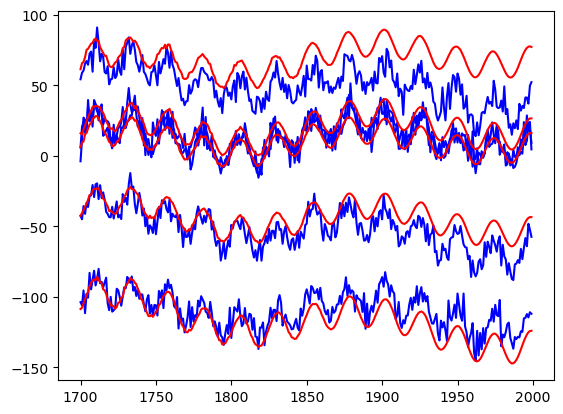

In [8]:
# plot true vs pred on test data

df_test['preds'] = model.predict(X_test[['unique_id']])

_ = df_test.groupby('unique_id')['y'].plot(c='blue')
_ = df_test.groupby('unique_id')['preds'].plot(c='red')

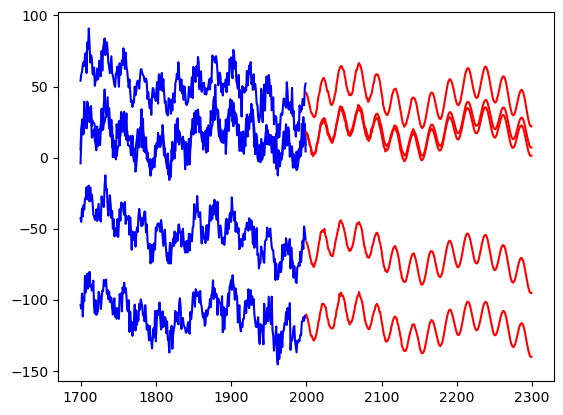

In [9]:
# plot pred on unseen data without the need to refit

X_new = pd.DataFrame({'unique_id': np.repeat(np.arange(n_series), test_size), 'preds': np.nan},
                    index=np.tile(np.arange(timesteps, timesteps+test_size), n_series))
X_new['preds'] = model.predict(X_new[['unique_id']], last_X=X_test[['unique_id']], last_y=y_test)

df_test = pd.concat([df_test.assign(preds=np.nan), X_new], axis=0)

_ = df_test.groupby('unique_id')['y'].plot(c='blue')
_ = df_test.groupby('unique_id')['preds'].plot(c='red')

In [10]:
# fit testing multiple parameter combination and exogenous varaibles

CV = TemporalSplit(1, test_size=24*7)

model = GridSearchCV(
    ForecastingCascade(
        Ridge(),
        lags=range(1,24*7+1),  
        groups=[0]
    ), 
    param_grid={
        'estimator__alpha': [1,2,3,5,10],
        'target_diff': [True, False],
        'target_standardize': [True, False],
        'exog_lags': [None, range(1,10)],
    },
    cv=CV, scoring='neg_mean_squared_error'
).fit(X_train, y_train)

print('BEST PARAMS: ', model.best_params_)
model.best_estimator_.score(X_test, y_test, scoring='mse')

BEST PARAMS:  {'estimator__alpha': 1, 'exog_lags': None, 'target_diff': True, 'target_standardize': True}


115.3157343759522